In [ ]:
import os
experiments = os.listdir('experiments')
experiments

In [ ]:
import torch
import os
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
from torch import nn
from torch.nn.functional import relu
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
import matplotlib.pyplot as plt
import math

from utils import SmokingCNN
model = SmokingCNN(window_size=3000, num_features=6)

base_model = SmokingCNN()
base_model.load_state_dict(torch.load(f'results/best_base_model.pt'))

custom_model = SmokingCNN()
custom_model.load_state_dict(torch.load(f'results/best_target_model.pt'))

batch_size = 512
fold = -1
    
data_path = f'data/001_test'
participants = ['alsaad','anam','asfik','ejaz','iftakhar','tonmoy','unk1','dennis']
target_participant = participants[fold]
participants.remove(target_participant)

base_train_dataset = ConcatDataset([TensorDataset(*torch.load(f'{data_path}/{p}_{s}.pt')) for p in participants for s in ['train', 'val']])
base_val_dataset = ConcatDataset([TensorDataset(*torch.load(f'{data_path}/{p}_test.pt')) for p in participants])

target_train_dataset = TensorDataset(*torch.load(f'{data_path}/{target_participant}_train.pt'))
target_val_dataset = TensorDataset(*torch.load(f'{data_path}/{target_participant}_val.pt'))
target_test_dataset = TensorDataset(*torch.load(f'{data_path}/{target_participant}_test.pt'))

base_valloader = DataLoader(base_val_dataset, batch_size=batch_size)
target_trainloader = DataLoader(target_train_dataset, batch_size=batch_size)
target_valloader = DataLoader(target_val_dataset, batch_size=batch_size)
target_testloader = DataLoader(target_test_dataset, batch_size=batch_size)

In [ ]:
from utils import evaluate
evaluate(base_model, target_testloader, device='cuda')
evaluate(custom_model, target_testloader, device='cuda')

Target train dataset size: 9026
Target val dataset size: 3524
Target test dataset size: 1504
              precision    recall  f1-score   support

  No Smoking       0.74      0.88      0.80      1025
     Smoking       0.56      0.32      0.41       479

    accuracy                           0.70      1504
   macro avg       0.65      0.60      0.61      1504
weighted avg       0.68      0.70      0.68      1504



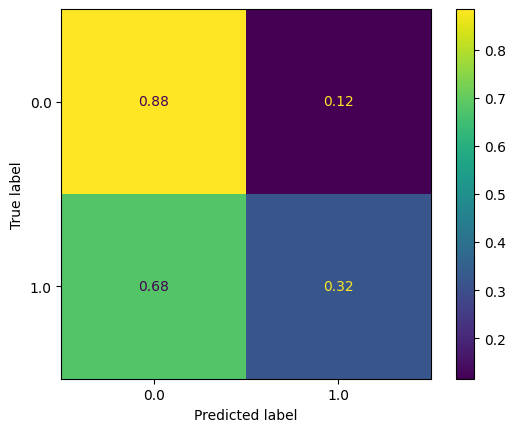

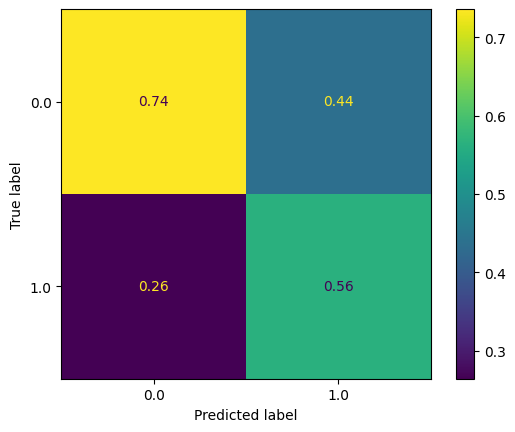

In [5]:
import os
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from torch import nn
from utils_simple import compute_loss, optimize_model_and_compute_loss, plot_loss, evaluate
import torch
import matplotlib.pyplot as plt

# Hyperparameters
lr = 3e-3
batch_size = 32
early_stopping_patience = 50
window_size = 3000
data_path = f'data/001_test'
target_participant = 'dennis'

target_train_dataset = TensorDataset(*torch.load(f'{data_path}/{target_participant}_train.pt'))
target_val_dataset = TensorDataset(*torch.load(f'{data_path}/{target_participant}_val.pt'))
target_test_dataset = TensorDataset(*torch.load(f'{data_path}/{target_participant}_test.pt'))

print(f'Target train dataset size: {len(target_train_dataset)}')
print(f'Target val dataset size: {len(target_val_dataset)}')
print(f'Target test dataset size: {len(target_test_dataset)}')

# from utils import SmokingCNN
from utils import SimpleSmokingCNN
model = SimpleSmokingCNN(window_size=window_size, num_features=6)
model.load_state_dict(torch.load('experiments/exp_0012/best_model.pt'))
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
device = 'cuda'

trainloader = DataLoader(target_train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(target_val_dataset, batch_size=batch_size)
testloader = DataLoader(target_test_dataset, batch_size=batch_size)

evaluate(model, testloader, device=device)